In [1]:
File_path = "/home/jovyan/steelelab/measurement_data/Triton/Jasper/HBAR_transmon_flipchip/" #internal NAS location of data

### IMPORTS ###
import glob, os, datacube, xarray, bokeh, time, math, scipy
import stlabutils;   # import stlab repository: https://github.com/steelelab-delft/stlab
import numpy as np

import matplotlib.pyplot  as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.pyplot import cm
import matplotlib.colors as mplcolors

### RC params ####
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', labelsize=10)    # axis labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=8)    # legend fontsize

# rc params linecuts
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.linestyle'] = ':'
plt.rcParams['lines.markersize'] = 1

# rc params general plotting:
plt.rcParams['xtick.direction'] = "in"
plt.rcParams['ytick.direction'] = "in"
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 250
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.format'] = 'pdf'#'png'#'jpg'

/opt/lib/stlabutils/stlabdict.py:908: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if func is '':


['Frequency (Hz)', ' CH2_S21_S1re ()', ' CH2_S21_S1im ()', ' CH2_S21_S1dB (dB)', ' CH2_S21_S1Ph (rad)', ' Probe Power (dBm)', ' Drive Power (dBm)', ' VNA Port 1 RT Attn (dB)', ' VNA Port 2 RT Attn (dB)', ' Line inside fridge Attn (dB)', ' Number Miteqs']


Text(-0.07, 1, '(b)')

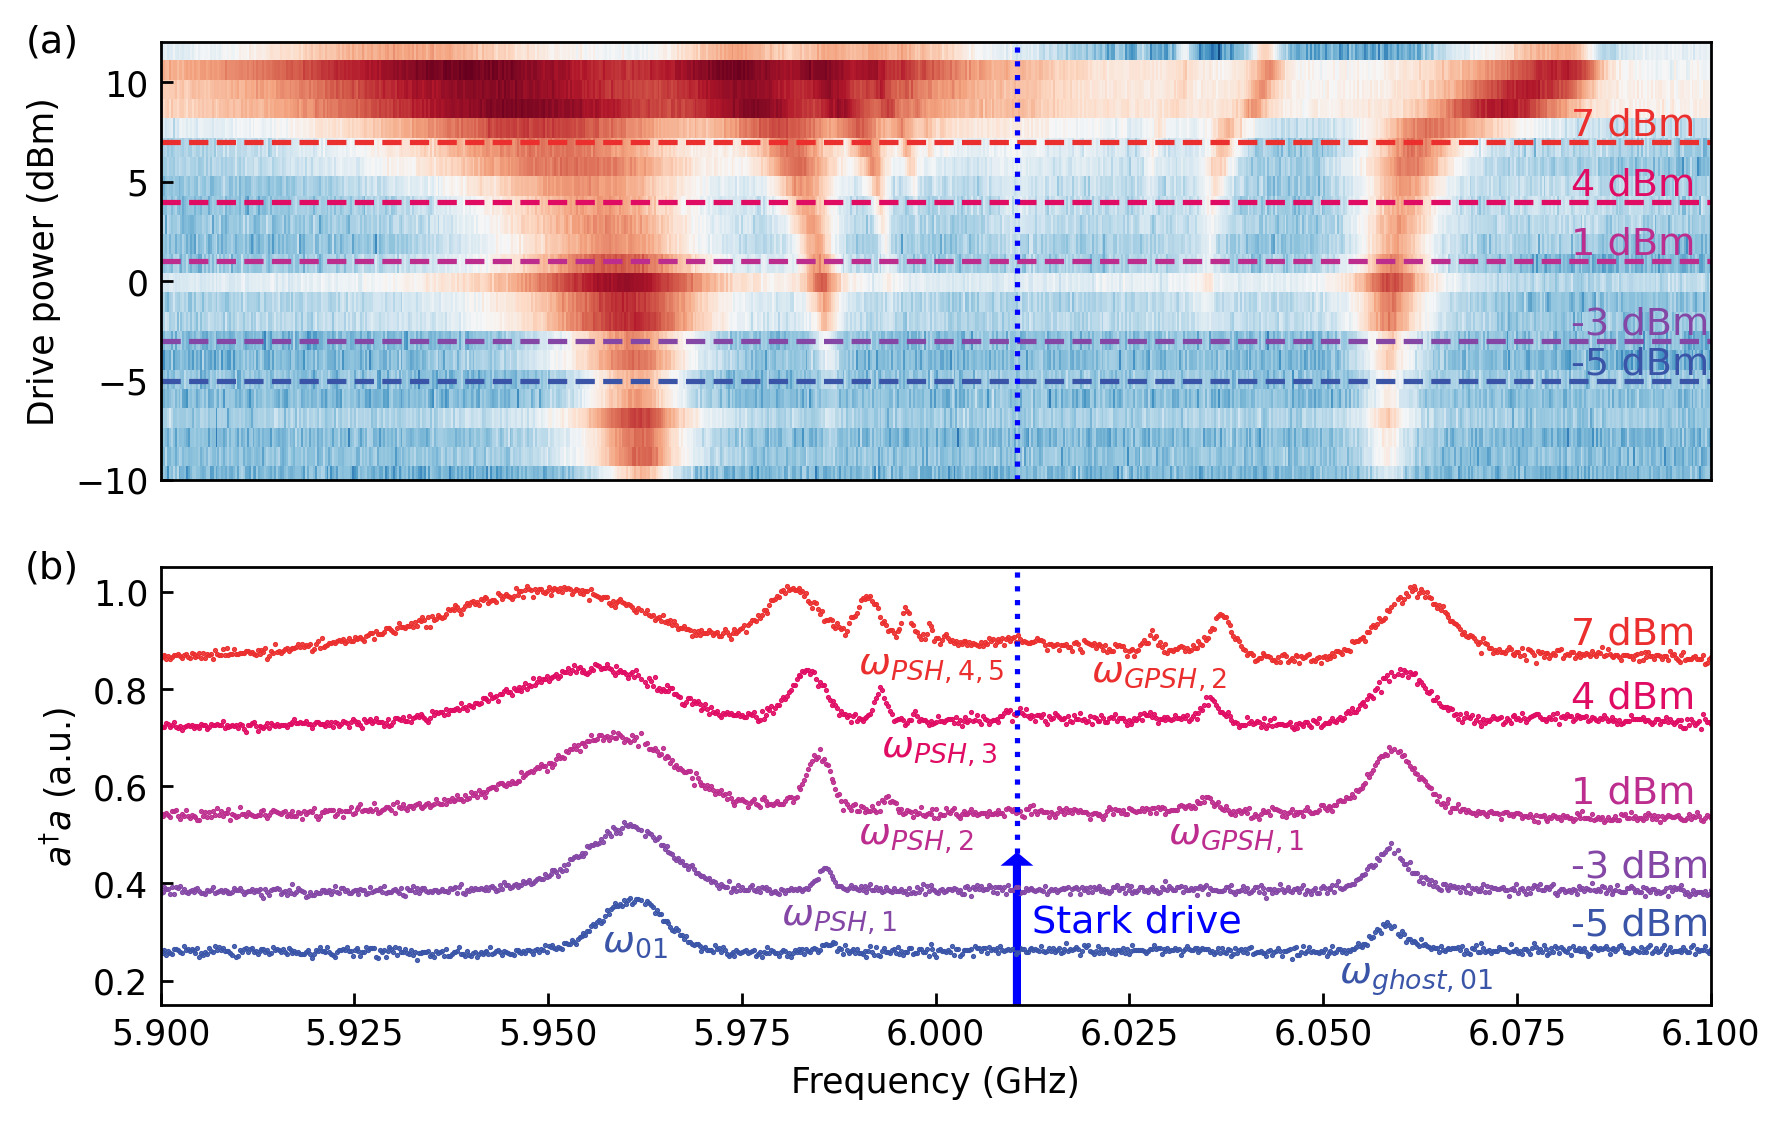

In [6]:
##LOAD File:
file_name = "Hbar_TT1_2023_06_12_12.06.29_segm_Qubit"; file_pre = File_path+file_name+'/'+file_name+'.dat';    
file = stlabutils.readdata.readdat(file_pre,delim=',');  
S21dB=[]; Drive_powers=[]

#### Settings and numbers: ####
col_maps = 'PuBu'
St_tone_color = 'blue'; vline_style= ':'
Stark_freq = 30e6 + 5.9805e9;       Stark_pow = -10.5 #dBm
HBAR_line = 6.05907;   HBAR_line2 = 5.96193;   
pnt_1 = 247;     pnt_2 = 1049 #HBAR 1
pnt_3 = 1435;    pnt_4 = 2237 #HBAR 2

## Powers I want to show:
Del_HBARs = 'Y'  #'N' or 'Y'
Drive_pows = [-5,-3,1,4,7]
# Drive_pows = list(np.linspace(-20,12,26))

##Extract wanted data:
Freq = file[0]['Frequency (Hz)'].values
Freq_cm = file[0]['Frequency (Hz)'].values

for i in np.arange(len(file)):
    ##load DATA
    S21Real = file[i][' CH2_S21_S1re ()'].values;    S21Imag = file[i][' CH2_S21_S1im ()'].values; 
    S21dB_pre = np.abs(S21Real + 1j*S21Imag);        S21dB.append(S21dB_pre);
    Drive_powers.append(file[i][' Drive Power (dBm)'].values[0])
#####################################################################################################################
### FIND RIGHT INDEX STARK POWER:
idx=[]
for i in np.arange(len(Drive_pows)):
    idx.append(int(np.argmin(np.abs(np.array(Drive_powers)-Drive_pows[i]))))

colors = cm.bone(np.linspace(0.2, 0.6, len(idx)))
colors = ['#3a55a8','#8447a6','#bc2d8e','#e00c64','#eb2e2e']

### DELETE HBAR LINES ####
#delete section: 
HBARs = [list(np.linspace(pnt_4,pnt_3,(pnt_4-pnt_3))), list(np.linspace(pnt_2,pnt_1,(pnt_2-pnt_1)))]

##Del HBAR cut in frequency:
if Del_HBARs=='Y':
    for i,l in enumerate(HBARs):
        HBAR = l
        for j,p in enumerate(HBAR):
            Freq = np.delete(Freq, int(p))
            
##Del HBAR cut in S21:
for qq in np.arange(len(S21dB)):
    if Del_HBARs=='Y':
        for i,l in enumerate(HBARs):
            HBAR = l
            for j,p in enumerate(HBAR):
                S21dB[qq] = np.delete(S21dB[qq], int(p))
            
##PLOT:
ghost_freq=[]; S21_ghost=[]

fig, (ax1,ax2) = plt.subplots(2)

#top color plot:
#create x,y,z for imshow colorplot    
x = Freq/1e9;           y = Drive_powers;         data = np.array(S21dB).reshape((len(y), len(x)))

#setting for scaling
scale_fact_Z = 1e4

### color plot:
c = ax1.imshow(data*scale_fact_Z, cmap = "RdBu_r", 
#                vmin = np.min(data)*scale_fact_Z, vmax = np.max(data)*scale_fact_Z*1.1, 
               aspect='auto', interpolation ='none',
               extent = [x[0], x[-1], y[0], y[-1]], alpha = 1,origin ='lower',
                       norm=mplcolors.PowerNorm(gamma=0.5))
ax1.set_xticks([])
ax1.set_ylabel('Drive power (dBm)'); 
ax1.tick_params(axis='both', which='major')

#bottom linecuts
plot_max = 0
for ii, k in enumerate(idx):
    if ii == 0:
        diff = 0
    else:
        diff = plot_max - np.min(S21dB[k]);   
    S21dB[k] = S21dB[k]+diff
    plot_max = np.max(S21dB[k])
    
    #set in colormap:
    ax1.axhline(y = Drive_pows[ii], color=colors[ii], linestyle = '--')
    ax1.text(6.082,Drive_pows[ii]+0.35,'{} dBm'.format(Drive_pows[ii]), color=colors[ii])
    
    #set in linecuts:
    ax2.plot(Freq/1e9,S21dB[k]*1e4,'.',color=colors[ii],lw=0.1)
    ax2.text(6.082,np.mean(S21dB[k][-20:])*1e4+0.03,'{} dBm'.format(Drive_pows[ii]), color=colors[ii])
    
ax2.set_xlabel('Frequency (GHz)')
ax2.set_ylabel(r'$a^{\dagger}a$ (a.u.)')
ax2.tick_params(axis='both', which='major')

ax1.axvline(x = Stark_freq/1e9, color=St_tone_color)

ax2.axvline(x = Stark_freq/1e9, color=St_tone_color,)
ax2.arrow(Stark_freq/1e9, 0.14, 0, 0.3, width=0.0006,head_length=0.02,head_width=0.003,color=St_tone_color)
ax2.text(Stark_freq/1e9+0.002, 0.3, r'Stark drive',color=St_tone_color, rotation = 0)

## text first plot line:
ax2.text(5.957, 0.26, r'$\omega_{01}$', color=colors[0], rotation = 0)
ax2.text(6.052, 0.195, r'$\omega_{ghost,01}$', color=colors[0], rotation = 0)
## text second plot line:
ax2.text(5.98, 0.315, r'$\omega_{PSH,1}$', color=colors[1], rotation = 0)
## text third plot line:
ax2.text(5.99, 0.48, r'$\omega_{PSH,2}$', color=colors[2], rotation = 0)
ax2.text(6.03, 0.48, r'$\omega_{GPSH,1}$', color=colors[2], rotation = 0)
## text fourth plot line:
ax2.text(5.993, 0.66, r'$\omega_{PSH,3}$', color=colors[3], rotation = 0)
# ax2.text(6.021, 0.66, r'$\omega_{GPSH,2}$', color=colors[3], rotation = 0)
## text fifth plot line:
ax2.text(5.99, 0.83, r'$\omega_{PSH,4,5}$', color=colors[4], rotation = 0)
ax2.text(6.02, 0.815, r'$\omega_{GPSH,2}$', color=colors[4], rotation = 0)

# #colorbar:   
# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("top", size="5%", pad=0.075)
# clb = plt.colorbar(c, cax=cax, pad=0.07)
# clb.ax.set_title(r'|$S_{21}$|',fontsize=7)

ax2.set_xlim([5.90,6.10]); ax2.set_ylim([0.15,1.05])
ax1.set_ylim([-10,12])

#figurelabel    
ax1.text(-0.07, 1, r'(a)', horizontalalignment='center', verticalalignment='center', 
        transform=ax1.transAxes, color='k')
ax2.text(-0.07, 1, r'(b)', horizontalalignment='center', verticalalignment='center', 
        transform=ax2.transAxes, color='k')

## Save data:
# plt.savefig('Figure4_paramSubh_ghosts',bbox_inches = 'tight')